In [1]:
#Import standard packages for model training

import tensorflow as T
from tensorflow import *
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
import sklearn.metrics as SK
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import io
from utils.GPU import *
from utils import utils
commons = utils.Commons()
ts_helper = utils.TS_Helper()
shap_helper = utils.Shap_Helper()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

  tensorlayer: GPU MEM Fraction 0.900000
Num GPUs Available:  1


In [2]:
#Inport train, validation and test sets

training = './data/regression/Tb.rhodesiense/random_split/train_fold_4.csv'
validation = './data/regression/Tb.rhodesiense/random_split/valid_fold_4.csv'
test = './data/regression/Tb.rhodesiense/random_split/test_fold_4.csv'

train_dataset = pd.read_csv(training, delimiter=',', low_memory=False)
val_dataset = pd.read_csv(validation, delimiter=',', low_memory=False)
test_dataset = pd.read_csv(test, delimiter=',', low_memory=False)


train_dataset.head()

,ID,SMILES,Tb_rhodesiense
0,2357,O=C(C1C=CC(C2NCCN=2)=CC=1)NC1C=C(C(NC2C=CC(C3N...,6.920819
1,291,CC1C=C(Br)C(NC2N=C(NC3C=CC(C#N)=CC=3)N=C(C#N)N...,4.877129
2,2054,FC(OC1C(Cl)=CC(CC(C(NC2(C#N)CC2)=O)NC(C2C=NN(C...,9.000000
3,3455,CCCCCCCCCCCCCCCCC1(C(=O)C(CCC)=C(O)S1)C,4.537602
4,2313,CN(C12CC(C3C=CC=CC=3)C(C(C3C=CC=CC=3)C1)C(OC(C...,7.096910


In [3]:
#Create y_train, y_test and y_test sets

task_start=2
tasks=1
task_index = tasks + 2
#print('tasks: %s' % tasks)

# load training dataset
train_dataset = pd.read_csv(training, delimiter=',', low_memory=False)
y_train = np.array(train_dataset.iloc[:,2:task_index].values)
print(f"loaded y_train data: {y_train.shape}")

# load validation dataset
val_dataset = pd.read_csv(validation, delimiter=',', low_memory=False)
y_val = np.array(val_dataset.iloc[:,2:task_index].values)
print(f"loaded y_val data: {y_val.shape}")

# load test dataset
test_dataset = pd.read_csv(test, delimiter=',', low_memory=False)
y_test = np.array(test_dataset.iloc[:,2:task_index].values)
print(f"loaded y_test data: {y_test.shape}")

loaded y_train data: (1430, 1)
loaded y_val data: (179, 1)
loaded y_test data: (179, 1)


In [4]:
# calculate ECFP (defaut) fingerprints using RDKit

from utils.fingerprints import *

train_smiles=train_dataset["SMILES"].values
val_smiles=val_dataset["SMILES"].values
test_smiles=test_dataset["SMILES"].values
X_train = assing_fp(train_smiles,FP_SIZE,RADIUS)
X_val = assing_fp(val_smiles,FP_SIZE,RADIUS)
X_test = assing_fp(test_smiles,FP_SIZE,RADIUS)

X_train.shape, X_val.shape, X_test.shape

((1430, 2048), (179, 2048), (179, 2048))

C:\Users\Predator\anaconda3\envs\ia\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                30735     
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

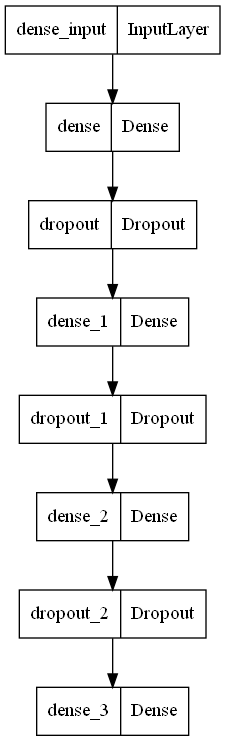

In [5]:
#Parameters for train network

from utils.utils import *

bit_vector = X_train.shape[1]

def create_model():
    return T.keras.models.Sequential([
            T.keras.layers.Dense(15,input_dim=bit_vector, activation='relu'),
            T.keras.layers.Dropout(0.3),
            T.keras.layers.Dense(10, activation='relu'),
            T.keras.layers.Dropout(0.1),
            T.keras.layers.Dense(10, activation='relu'),
            T.keras.layers.Dropout(0.1),
            T.keras.layers.Dense(tasks, activation='linear'),
            ])

       
optimizer = RMSprop(lr=0.001)
lr_metric = get_lr_metric(optimizer)
model = create_model()
model.compile(loss=regression_loss, metrics = [lr_metric])    
model.summary()
T.keras.utils.plot_model(model)

In [6]:
# Early stopping parameters

callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00000001, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="./data/TM-FNN_regression_model.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', verbose=1)
    ]


# parameters for train network

epochs=1000
batch_size=40

history = model.fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=(callbacks_list))

Epoch 1/1000
34/36 [===========================>..] - ETA: 0s - loss: 20.5092 - lr: 1.0000e-03
Epoch 1: val_loss improved from inf to 7.25075, saving model to ./data\TM-FNN_regression_model.hdf5
36/36 [==============================] - 2s 13ms/step - loss: 19.9891 - lr: 0.0010 - val_loss: 7.2508 - val_lr: 0.0010
Epoch 2/1000
24/36 [===================>..........] - ETA: 0s - loss: 6.4563 - lr: 0.0010
Epoch 2: val_loss improved from 7.25075 to 2.25738, saving model to ./data\TM-FNN_regression_model.hdf5
36/36 [==============================] - 0s 7ms/step - loss: 6.1009 - lr: 0.0010 - val_loss: 2.2574 - val_lr: 0.0010
Epoch 3/1000
23/36 [==================>...........] - ETA: 0s - loss: 4.6916 - lr: 0.0010
Epoch 3: val_loss improved from 2.25738 to 1.60285, saving model to ./data\TM-FNN_regression_model.hdf5
36/36 [==============================] - 0s 7ms/step - loss: 4.6671 - lr: 0.0010 - val_loss: 1.6029 - val_lr: 0.0010
Epoch 4/1000
34/36 [===========================>..] - ETA: 0s - 


Epoch 31: val_loss did not improve from 0.74393
36/36 [==============================] - 0s 6ms/step - loss: 1.0023 - lr: 0.0010 - val_loss: 0.7834 - val_lr: 0.0010
Epoch 31: early stopping


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


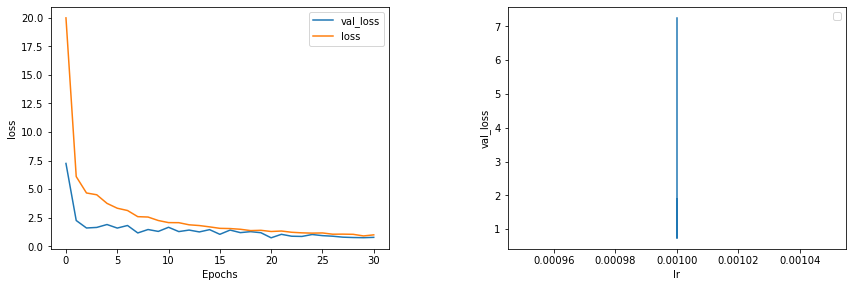

In [7]:
#Plot model history
ts_helper.plot_history(history)

6/6 [==============================] - 0s 3ms/step
Results for task 1 (train)
r^2	0.90
rmse	0.87
mse	0.76
mae	0.70
Results for task 1 (validation)
r^2	0.80
rmse	0.89
mse	0.78
mae	0.71
Results for task 1 (test)
r^2	0.81
rmse	0.88
mse	0.77
mae	0.70


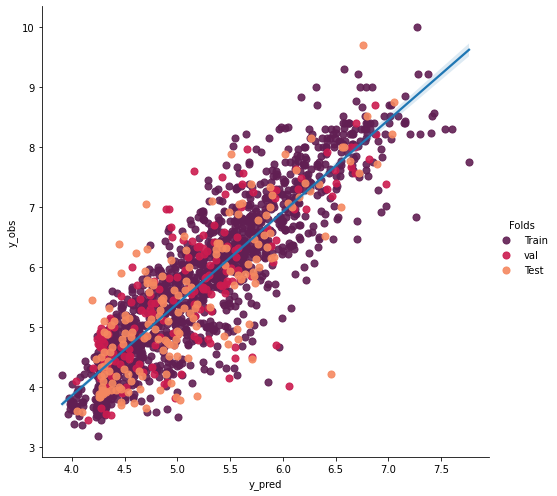

In [8]:
#Statistical characteristico of model without 3-sigma rule

prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test)


for index1 in range(prediction_train.shape[1]):

    train_pred = pd.DataFrame(y_train[:,index1],prediction_train[:,index1]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'y_obs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['y_obs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3

    for index2 in range(prediction_val.shape[1]):
         
        val_pred = pd.DataFrame(y_val[:,index2],prediction_val[:,index2])
        val_pred['y_pred'] = val_pred.index
        val_pred = val_pred.rename(columns = {0: 'y_obs'})
        val_pred2 = val_pred.dropna()
        val_pred2 = val_pred2.reset_index(drop=True)
        val_pred2['Folds'] = 'val'
        val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['y_obs']))
        val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
          
        for index3 in range(prediction_test.shape[1]):
         
            test_pred = pd.DataFrame(y_test[:,index3],prediction_test[:,index3])
            test_pred['y_pred'] = test_pred.index
            test_pred = test_pred.rename(columns = {0: 'y_obs'})
            test_pred2 = test_pred.dropna()
            test_pred2 = test_pred2.reset_index(drop=True)
            test_pred2['Folds'] = 'Test'
            test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['y_obs']))
            test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3

            crossval_df = pd.concat([train_pred2, val_pred2, test_pred2], axis=0).reset_index(drop=True)

            if index1 == index2 and index1 == index3:
                    
                r2  = (train_pred2["y_obs"].corr(train_pred2["y_pred"]))    
                print(("Results for task {} (train)").format(index2+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f" % sqrt(mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mse\t%.2f" % (mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mae\t%.2f"  %mean_absolute_error(train_pred2["y_obs"],train_pred2["y_pred"]))   

                r2 = (val_pred2["y_obs"].corr(val_pred2["y_pred"]))
                print(("Results for task {} (validation)").format(index3+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mse\t%.2f"  % (mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(val_pred2["y_pred"],val_pred2["y_obs"]))
                
                r2 = (test_pred2["y_obs"].corr(test_pred2["y_pred"])) 
                print(("Results for task {} (test)").format(index1+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"]))) 
                print ("mse\t%.2f"  % (mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(test_pred2["y_pred"],test_pred2["y_obs"]))

                g = sns.lmplot(x="y_pred", y="y_obs", hue="Folds", data=crossval_df, fit_reg=False, height=7, 
                markers=["o", "o", "o"], palette="rocket",scatter_kws={"s": 50,'alpha':0.9},  aspect=30/30)
                sns.regplot(x="y_pred", y="y_obs", data=crossval_df, scatter=False, ax=g.axes[0, 0]) 

Results for task 1 (train)
r^2	0.90
rmse	0.72
mse	0.51
mae	0.60
Results for task 1 (validation)
r^2	0.84
rmse	0.75
mse	0.56
mae	0.62
Results for task 1 (test)
r^2	0.84
rmse	0.73
mse	0.53
mae	0.60


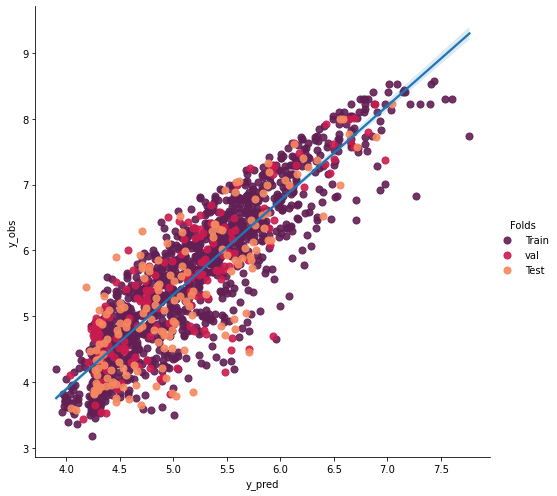

In [9]:
#Statistical characteristico of model using 3-sigma rule

for index1 in range(prediction_train.shape[1]):

    train_pred = pd.DataFrame(y_train[:,index1],prediction_train[:,index1]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'y_obs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['y_obs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3
    train_pred2=train_pred2[train_pred2['Folds_error']<=(train_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

    for index2 in range(prediction_val.shape[1]):
         
        val_pred = pd.DataFrame(y_val[:,index2],prediction_val[:,index2])
        val_pred['y_pred'] = val_pred.index
        val_pred = val_pred.rename(columns = {0: 'y_obs'})
        val_pred2 = val_pred.dropna()
        val_pred2 = val_pred2.reset_index(drop=True)
        val_pred2['Folds'] = 'val'
        val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['y_obs']))
        val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
        val_pred2=val_pred2[val_pred2['Folds_error']<=(val_pred2['Folds error 3*sigma'])]#keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
   
        for index3 in range(prediction_test.shape[1]):

            test_pred = pd.DataFrame(y_test[:,index3],prediction_test[:,index3])
            test_pred['y_pred'] = test_pred.index
            test_pred = test_pred.rename(columns = {0: 'y_obs'})
            test_pred2 = test_pred.dropna()
            test_pred2 = test_pred2.reset_index(drop=True)
            test_pred2['Folds'] = 'Test'
            test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['y_obs']))
            test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3
            test_pred2=test_pred2[test_pred2['Folds_error']<=(test_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

            crossval_df = pd.concat([train_pred2, val_pred2, test_pred2], axis=0).reset_index(drop=True)

            if index1 == index2 and index1 == index3:
                        
                r2 = (train_pred2["y_obs"].corr(train_pred2["y_pred"]))    
                print(("Results for task {} (train)").format(index2+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f" % sqrt(mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mse\t%.2f" % (mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mae\t%.2f"  %mean_absolute_error(train_pred2["y_obs"],train_pred2["y_pred"]))   

                r2 = (val_pred2["y_obs"].corr(val_pred2["y_pred"]))
                print(("Results for task {} (validation)").format(index3+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mse\t%.2f"  % (mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(val_pred2["y_pred"],val_pred2["y_obs"]))
                
                r2 = (test_pred2["y_obs"].corr(test_pred2["y_pred"])) 
                print(("Results for task {} (test)").format(index1+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"]))) 
                print ("mse\t%.2f"  % (mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(test_pred2["y_pred"],test_pred2["y_obs"]))

                g = sns.lmplot(x="y_pred", y="y_obs", hue="Folds", data=crossval_df, fit_reg=False, height=7, 
                markers=["o", "o", "o"], palette="rocket",scatter_kws={"s": 50,'alpha':0.9},  aspect=30/30)
                sns.regplot(x="y_pred", y="y_obs", data=crossval_df, scatter=False, ax=g.axes[0, 0]) 